In [22]:
"""
File: Mini-project.ipynb
Author: Simon Loi Baks
Date: 06/03/2024
Description: This script contains multiple implementations of different Mandelbrot set algorithms.
"""

'\nFile: Mini-project.ipynb\nAuthor: Simon Loi Baks\nDate: 06/03/2024\nDescription: This script contains multiple implementations of different Mandelbrot set algorithms.\n'

# Mini-Project Numerical Scientific Computing

1. one or more updated versions of your previous code (naive, numpy or multiprocessing) where you investigate the achievable gain from using other data types, e.g., numpy.float32 instead of numpy.float64, etc. Please include execution time results for the original and optimized code.
2. Dask-version of the mandelbrot algorithm with execution time results for:
   multi-core execution on a single computer. Compare the results to your normal numpy vectorized implementation.
   cluster execution, either on strato cluster or another type of job-server/workstation (for example with own laptop+desktop computers or 2 or more laptops in group room).


# Importing libraries


In [23]:
# Importing libraries
import matplotlib.pyplot as plt
import multiprocessing as mp

# from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Union
import dask.array as da
from tqdm import tqdm
from numba import jit
import numpy as np
import cv2 as cv
import timeit
import time

# Naive algorithm for computing Mandelbrot set


##### Naive Mandelbrot Algorithm


In [24]:
def NaiveMandelbrot(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float]) -> np.ndarray:
    """Naive implementation of the Mandelbrot Set Algorithm based on the pseudocode from `https://en.wikipedia.org/wiki/Mandelbrot_set`.
    
    The function calculates a set of points in the complex-plane (converted to the real plane) which forms a fractal. 
    The x and y locations of each point are used as starting values in a repeating, or iterating calculation. 
    The result of each iteration is used as the starting values for the next. 
    The values are checked during each iteration to see whether they have reached a critical "escape" condition, or "bailout". 
    If that condition is reached, the calculation is stopped, the pixel is drawn, and the next x, y point is examined


    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Iterate through each pixel coordinate
    for Px in tqdm(range(width), total=width, desc="Computing Mandelbrot Set"):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            while iter < max_iter and z_Real * z_Real + z_Imgy * z_Imgy <= T * 2:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real * z_Real - z_Imgy * z_Imgy + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                img[Py, Px] = 255
            else:
                img[Py, Px] = iter

    return img

# Mandelbrot algorithm using Numpy vectorization


Performing vectorization on the naive Mandelbrot Algorithm implementation


In [25]:
def VectorizedMandelbrot(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float]) -> np.ndarray:
    """Similar to the naive implementation but instead its vectorized.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Creating np arrays for width/height pixels
    Px = np.linspace(min_real, max_real, width)
    Py = np.linspace(min_imaginary, max_imaginary, height)
    c = Px[np.newaxis, :] + 1j * Py[:, np.newaxis]

    # Initialize z as 0's, iter, and mask arrays
    z = np.zeros_like(c, dtype=np.complex128)
    iter = np.zeros(c.shape, dtype=np.int32)
    mask = np.full(c.shape, True, dtype=bool)

    # Using logical mask to check for divergence or escaped points
    t1 = time.time()
    for i in tqdm(range(int(max_iter)), total=int(max_iter), desc="Computing Mandelbrot Set"):
        z[mask] = z[mask] * z[mask] + c[mask]
        mask = np.logical_and(mask, abs(z) < T)
        iter[mask] = i

    img[:, :] = iter
    print(f"Execution time: {time.time() - t1:.2f}s")

    return img

##### Dask vectorized version

In [ ]:
def daskVectorizedMandelbrot(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float]) -> np.ndarray:
    """Similar to the naive implementation but instead its a dask vectorized-version.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Creating np arrays for width/height pixels
    Px = np.linspace(min_real, max_real, width)
    Py = np.linspace(min_imaginary, max_imaginary, height)
    c = Px[np.newaxis, :] + 1j * Py[:, np.newaxis]

    # Initialize z as 0's, iter, and mask arrays
    z = np.zeros_like(c, dtype=np.complex128)
    iter = np.zeros(c.shape, dtype=np.int32)
    mask = np.full(c.shape, True, dtype=bool)

    # Using logical mask to check for divergence or escaped points
    t1 = time.time()
    for i in tqdm(range(int(max_iter)), total=int(max_iter), desc="Computing Mandelbrot Set"):
        z[mask] = z[mask] * z[mask] + c[mask]
        mask = np.logical_and(mask, abs(z) < T)
        iter[mask] = i

    img[:, :] = iter
    print(f"Execution time: {time.time() - t1:.2f}s")

    return img

# Naive Mandelbrot Algorithm using Numba jit


In [26]:
@jit(nopython=True, fastmath=True, cache=True)
def NaiveMandelbrotNumba(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float], datatype=np.float32) -> np.ndarray:
    """Similar to the naive implementation but instead its using numba jit.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.
        datatype (np.float32):
            Numpy datatype.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    # Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Mandelbrot_set
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Iterate through each pixel coordinate
    for Px in range(width):
        for Py in range(height):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = datatype(min_real + (max_real - min_real) * (Px / width))
            c_Imgy = datatype(min_imaginary + (max_imaginary - min_imaginary) * (Py / height))

            # Initialize z as 0
            z_Real = datatype(0)
            z_Imgy = datatype(0)

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            while iter < max_iter and z_Real**2 + z_Imgy**2 <= T * 2:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real**2 - z_Imgy**2 + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                img[Py, Px] = 255
            else:
                img[Py, Px] = iter

    return img

# Parallel Mandelbrot Algorithm


In [27]:
def MandelbrotChunk(chunk_start:int, chunk_end:int, width:np.uint8, height:np.uint8, params:List[float]) -> np.ndarray:
    """Similar to the naive implementation of the Mandelbrot Set Algorithm, but instead iterates through each point based on the chunk starting and ending points.

    Args:
        chunk_start (int): 
            The starting chunk in the list of chunks.
        chunk_end (int): 
            The ending chunk in the list of chunks.
        width (np.uint8): 
            The width of the image.
        height (np.uint8): 
            The height of the image.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float, str, int]`.

    Returns:
        np.ndarray:
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T, *_ = params

    # Initialize an empty array to store the chunk
    chunk = np.zeros((chunk_end - chunk_start, width), dtype=np.uint8)

    # Iterating through a chunk of the image
    for Px in range(width):
        for Py in range(chunk_start, chunk_end):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            while z_Real * z_Real + z_Imgy * z_Imgy <= T * 2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real * z_Real - z_Imgy * z_Imgy + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                color = 255
                chunk[Py - chunk_start, Px] = color
            else:
                chunk[Py - chunk_start, Px] = iter

    return chunk


def chunking(check: str, num_processes: int, height: np.uint8) -> list:
    """Generates `n` number of chunks based on either equal or dynamic chunking.

    Args:
        check (str): 
            A conditional string used to select the type of chunking scheme.
        num_processes (int): 
            The total number of processes.
        height (np.uint8): 
        The height of the image.

    Returns:
        list:
            Returns a list of chunking sizes.
    """
    if check == "equal":
        # Dividing image in equal chunks based on number of processes
        chunk_size = height // num_processes
        chunks = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes)]

        # If the last chunk size != height, we add the remainder of pixels to the last chunk
        if chunks[-1][1] != height:
            chunks[-1] = (chunks[-1][0], height)

        return chunks

    elif check == "dynamic":
        # Using dynamic chunking based on number of processed and image size
        avg_chunk_size = height / num_processes
        remaining_height = height % num_processes
        chunks = []
        start = 0

        # Check if remaining height is less than numnber of processes
        # if yes, increase chunk size for making even chunks
        for i in range(num_processes):
            chunk_size = int(avg_chunk_size)
            if i < remaining_height:
                chunk_size += 1
            end = start + chunk_size
            chunks.append((start, end))
            start = end

        return chunks
    else:
        print("Error! *Wrong parameter*")


def ParallelMandelbrot(width:np.uint8, height:np.uint8, img:np.ndarray, params:Tuple[float,float,float,float,float,float,str,int]) -> np.ndarray:
    """Initializes a multiprocessing pool which distributes the computation of the Mandelbrot Set to `n` number of processes.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (Tuple[float,float,float,float,float,float,str,int]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a list type: `List[float, float, float, float, float, float, str, int]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    *_, check, P = params

    # Create process pool and apply chunking scheme
    pool = mp.Pool(processes=P)
    chunks = chunking(check, P, height)
    print()
    print("type:", check)
    print("processes:", P)
    print("chunks", chunks)

    # Assigning a chunk to each process
    results = []
    t1 = time.time()
    for chunk_start, chunk_end in chunks:
        results.append(pool.apply_async(MandelbrotChunk, (chunk_start, chunk_end, width, height, params)))

    # Combine each image chunk to create full image
    for result, (chunk_start, chunk_end) in zip(results, chunks):
        img[chunk_start:chunk_end] = result.get()

    # Close and wait for process termination -> Good practice!
    pool.close()
    pool.join()

    t2 = time.time()
    t = t2 - t1
    print(f"Execution time: {t:.2f}s")

    return img, t

def runParallel(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float]) -> np.ndarray:
    """Runs the Mandelbrot Set Algorithm in parallel.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params
    processes = mp.cpu_count()
    P_values = range(1, processes + 1)
    times1 = []
    #times2 = []
    for i in range(processes):
        params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "equal", i + 1]
        img1, t = ParallelMandelbrot(width, height, img, params)
        times1.append(t)

        #params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "dynamic", i + 1]
        #img2, t = ParallelMandelbrot(width, height, img, params)
        #times2.append(t)

    print(f"\nChunking: Equal\nTotal Time: {np.array(times1).sum()}")
    #print(f"\nChunking: Dynamic\nTotal Time: {np.array(times2).sum()}")

    #displayMandelbrot(img1, params, "Parallel\n- equal chunking", "hot")
    #displayMandelbrot(img2, params, "Parallel\n- dynamic chunking", "hot")

    plot_results(P_values, times1, "equal")
    #plot_results(P_values, times2, "dynamic")


def plot_results(P_values:int, time_values:List[float], chunk:str) -> None:
    """Plots the execution time and speedup over the number of `n` number of processes.

    Args:
        P_values (int): _description_
        time_values (List[float]): _description_
        chunk (str): _description_
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Performance Analysis of Parallel Mandelbrot Algorithm\nChunking: {chunk}", fontsize=16)

    axs[0].set_title(f"Execution Time")
    axs[0].plot(P_values, time_values, marker="o", color="b")
    axs[0].set_xlabel("Number of Processes")
    axs[0].set_ylabel("Execution Time [s]")

    speedup = [time_values[0] / t for t in time_values]

    axs[1].set_title(f"Speedup")
    axs[1].plot(P_values, speedup, marker="o", color="r")
    axs[1].set_xlabel("Number of Processes")
    axs[1].set_ylabel("Speedup")

    plt.tight_layout()
    plt.show()

##### Using multiprocessing + numba jit


In [28]:
@jit(nopython=True, fastmath=True, cache=True)
def MandelbrotChunkJIT(chunk_start:int, chunk_end:int, width:np.uint8, height:np.uint8, params:List[float]) -> np.ndarray:
    """Similar to the naive implementation of the Mandelbrot Set Algorithm, but instead iterates through each point based on the chunk starting and ending points.

    Args:
        chunk_start (int): 
            The starting chunk in the list of chunks.
        chunk_end (int): 
            The ending chunk in the list of chunks.
        width (np.uint8): 
            The width of the image.
        height (np.uint8): 
            The height of the image.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float, str, int]`.

    Returns:
        np.ndarray:
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params

    # Initialize an empty array to store the chunk
    chunk = np.zeros((chunk_end - chunk_start, width), dtype=np.uint8)

    # Iterating through a chunk of the image
    for Px in range(width):
        for Py in range(chunk_start, chunk_end):
            # Map pixel coordinates to real and imaginary parts of c
            c_Real = min_real + (max_real - min_real) * (Px / width)
            c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)

            # Initialize z as 0
            z_Real = 0
            z_Imgy = 0

            # Initialize iterations
            iter = 0

            # Calculate the Mandelbrot iteration until the threshold
            while z_Real * z_Real + z_Imgy * z_Imgy <= T * 2 and iter < max_iter:
                # Calculate the next iteration of the real and imginary part of z
                next_z_Real = z_Real * z_Real - z_Imgy * z_Imgy + c_Real
                next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy

                # Assign the calculated parts to z as the new starting point
                z_Real = next_z_Real
                z_Imgy = next_z_Imgy

                # Increase iteration
                iter += 1

            # Checking if i(c) is in the Mandelbrot set
            if iter == max_iter:
                # In the Mandelbrot set
                color = 255
                chunk[Py - chunk_start, Px] = color
            else:
                chunk[Py - chunk_start, Px] = iter

    return chunk


def ParallelMandelbrotJIT(width:np.uint8, height:np.uint8, img:np.ndarray, params:Tuple[float,float,float,float,float,float,str,int]) -> np.ndarray:
    """Initializes a multiprocessing pool which distributes the computation of the Mandelbrot Set to `n` number of processes.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (Tuple[float,float,float,float,float,float,str,int]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a list type: `List[float, float, float, float, float, float, str, int]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    *_, check, P = params

    # Create process pool and apply chunking scheme
    pool = mp.Pool(processes=P)
    chunks = chunking(check, P, height)
    print()
    print("type:", check)
    print("processes:", P)
    print("chunks", chunks)

    # Assigning a chunk to each process
    results = []
    t1 = time.time()
    for chunk_start, chunk_end in chunks:
        results.append(pool.apply_async(MandelbrotChunkJIT, (chunk_start, chunk_end, width, height, params[:-2])))

    # Combine each image chunk to create full image
    for result, (chunk_start, chunk_end) in zip(results, chunks):
        img[chunk_start:chunk_end] = result.get()

    # Close and wait for process termination -> Good practice!
    pool.close()
    pool.join()

    t2 = time.time()
    t = t2 - t1
    print(f"Execution time: {t:.2f}s")

    return img, t

def runParallelJIT(width:np.uint8, height:np.uint8, img:np.ndarray, params:List[float]) -> np.ndarray:
    """Runs the Mandelbrot Set Algorithm in parallel.

    Args:
        width (np.uint8): 
                Width of the image.
        height (np.uint8): 
                Height of the image.
        img (np.ndarray): 
            Empty (zeroed) numpy array serving as image placeholder.
        params (List[float]): 
            List containing multiple parameters such as the min-max real and imaginary parts, max number of iterations, and threshold.
            Must be a: `List[float, float, float, float, float, float]`.

    Returns:
        np.ndarray: 
            Returns the Mandelbrot Set.
    """
    min_real, max_real, min_imaginary, max_imaginary, max_iter, T = params
    processes = mp.cpu_count()
    P_values = range(1, processes + 1)
    times1 = []
    times2 = []
    for i in range(processes):
        params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "equal", i + 1]
        img1, t = ParallelMandelbrotJIT(width, height, img, params) # JIT
        times1.append(t)

        params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T, "dynamic", i + 1]
        img2, t = ParallelMandelbrotJIT(width, height, img, params) # JIT
        times2.append(t)

    print(f"\nChunking: Equal\nTotal Time: {np.array(times1).sum()}")
    print(f"\nChunking: Dynamic\nTotal Time: {np.array(times2).sum()}")

    #displayMandelbrot(img1, params, "Parallel\n- equal chunking", "hot")
    #displayMandelbrot(img2, params, "Parallel\n- dynamic chunking", "hot")

    plot_results(P_values, times1, "equal")
    plot_results(P_values, times2, "dynamic")

# Displaying the Mandelbrot set in the complex plane


##### Function to display Mandelbrot


In [29]:
def displayMandelbrot(img:np.ndarray, params:List[float], title:str, cmap:Union[str, None] = None) -> None:
    min_real, max_real, min_imaginary, max_imaginary, *_ = params
    plt.imshow(img, cmap=cmap, extent=(min_real, max_real, min_imaginary, max_imaginary))
    plt.xlabel("Real(c)")
    plt.ylabel("Imaginary(c)")
    plt.title("Mandelbrot Set\n- " + f"{title}")
    plt.show()
    
def datatypes_plot(datatypes, time_values):
    plt.figure(figsize=(12, 6))
    plt.title(f"Performance Analysis of Mandelbrot Algorithm Datatypes", fontsize=16)
    plt.plot(datatypes, time_values, marker="o", color="b")
    plt.xlabel("Datatypes")
    plt.ylabel("Execution Time [s]")
    plt.show()

# Defining image and complex variables


In [30]:
# Defining image size
width = 5000
height = width
img = np.zeros((height, width), dtype=np.uint8)

# Defining max iterations
max_iter = 100.0

# Defining threshold
T = 2.0

# Defining the range of values for
# the real and imaginary parts of c
min_real = -2.0
max_real = 1.0
min_imaginary = -1.5
max_imaginary = 1.5
params = [min_real, max_real, min_imaginary, max_imaginary, max_iter, T]

### Running algorithms



- Numba Mandelbrot Algorithm -
'warmup' Execution time: 3.97s

- Numba Mandelbrot Algorithm -
'compiled' Execution time: 3.24s
'compiled' Execution time: 3.08s
[3.238746166229248, 3.084773302078247]


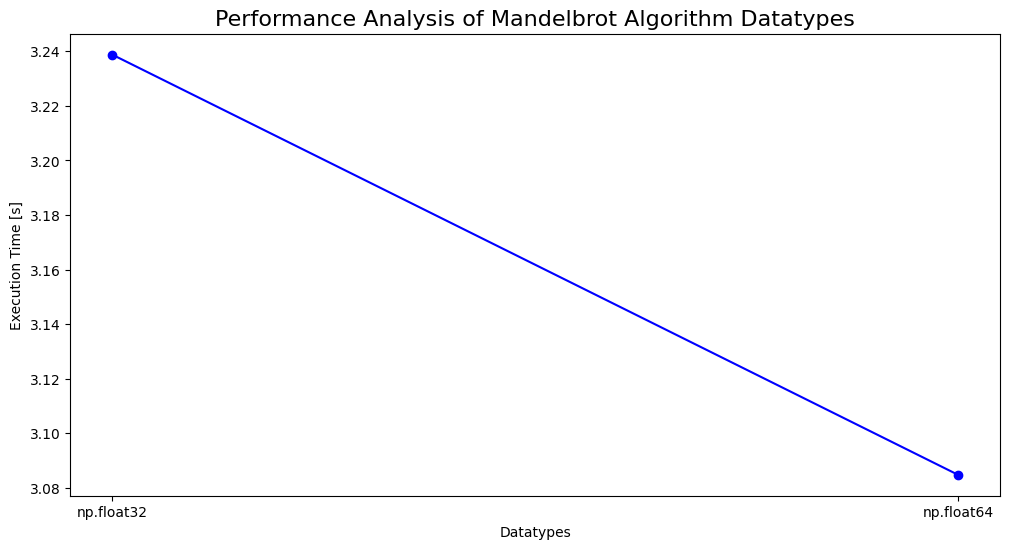

In [31]:
if __name__ == "__main__":
    # Naive Mandelbrot Algorithm
    #print(f"\n- Naive Mandelbrot Algorithm -")
    #t = time.time()
    #img_mandel = NaiveMandelbrot(width, height, img, params)
    #print(f"Execution time: {time.time() - t:.2f}s")
    #displayMandelbrot(img_mandel, params, "Naive", "hot")

    # Vectorized Mandelbrot Algorithm
    #print(f"\n- Vectorized Mandelbrot Algorithm -")
    #t = time.time()
    #img_mandel = VectorizedMandelbrot(width, height, img, params)
    #print(f"Execution time: {time.time() - t:.2f}s")
    #displayMandelbrot(img_mandel, params, "Vectorized", "hot")

    # Numba jit Optimized Mandelbrot Algorithm
    print(f"\n- Numba Mandelbrot Algorithm -")
    t = time.time()
    img_mandel1 = NaiveMandelbrotNumba(width, height, img, params)
    print(f"'warmup' Execution time: {time.time() - t:.2f}s")
    #displayMandelbrot(img_mandel1, params, "Numba", "hot")
    
    datatypes = [np.float32, np.float64]
    times = []
    print(f"\n- Numba Mandelbrot Algorithm -")
    for datatype in datatypes:
        t = time.time()
        img_mandel1 = NaiveMandelbrotNumba(width, height, img, params, datatype)
        t2 = time.time() - t
        print(f"'compiled' Execution time: {t2:.2f}s")
        times.append(t2)
    
    datatypes_plot(["np.float32", "np.float64"], times)
    #displayMandelbrot(img_mandel1, params, "Numba", "hot")

    # Parallel Mandelbrot Algorithm
    runParallel(width, height, img, params)
    #runParallelJIT(width, height, img, params)